# Ensemble Models and Hyperparameters Tunning

In this notebook, you will find the ensemble models using the best models from the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/baseline-models.ipynb">Vanilla Models</a> notebook. I'll focus on Voting Classifier and take a look how the models would perform with one iteration. Then I will using Bagging, which allows training instances to be sampled several times accross multiple predictor.

Next, I will run a GridSearch with Random Forest, Logistic Regression, and SVC. Although Logistic Regression did not perform as well as the other two models, I believe it has potential with hyperparameter tuning.

## Objectives

- Import datasets
- Run ensemble models for the best performing models
- Evaluate models

***

# Import Packages

In [306]:
# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP Packages
from nltk.corpus import stopwords

# Sklearn Packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

import pickle

## Importing Train and Test Set

The evaluation metric below will simplify the model evaluation. My main focus is the accuracy metric. Have an accurate is important to be accurate. However, although fixing False Negatives is not crucial, I will also take a look at Recall and F1-Score to understand how my model is working. Since it is not my main focus, I will not mentioned in the individual analysis on my models.

In [162]:
# Importing X and y variables
X_train = pickle.load(open('../pickle/X_train_tfidf.pkl', 'rb'))
X_test = pickle.load(open('../pickle/X_test_tfidf.pkl', 'rb'))
y_train = pd.read_pickle('../pickle/y_train.pkl')
y_test = pd.read_pickle('../pickle/y_test.pkl')

## Evaluation Metric

The evaluation metric below will simplify the model evaluation. My main focus is the accuracy metric. Have an accurate is important to be accurate. However, although fixing False Negatives is not crucial, I will also take a look at Recall and F1-Score to understand how my model is working. Since it is not my main focus, I will not mentioned in the individual analysis on my models.

In [174]:
# %load ../functions/evaluation.py
# Evaluation function

def evaluation(y_true, y_pred):

    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_true, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_true, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_true, y_pred)))

In [182]:
# %load ../functions/evaluation_df.py
# Evaluation DataFrame
def df_metrics():
    evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
    evaluation_df = evaluation_df.sort_values(by='Accuracy', ascending=False)
    return evaluation_df
    

***

# Ensamble Models

In this section, I will try different ensemble models. Random Forest is also considered a ensemble model. However, since it's a collection of decision tree and random forest tend to run better than decision trees, I decided to save time and skip the decision tree. I also did not use XGBoost because I had problems installing the package. It will be added to my stretch goal. Thus, I'd need to have another tokenized dataset with a different train test split, which would create a different dataset then the one that I'm using for all the models.

These are the models that I will run:
- Voting Classifier
- Bagging
- GridSearch with Random Forest
- GridSearch with Logistic Regression
- GridSearch with SVC
- ADABoost
- Gradient Boosting

## Instantiate Models

First, I will run a voting classifier with Logistic Regression, Random Forest, and SVC.

In [40]:
# Instantiate Logistic Regression
log_clf = LogisticRegression()

# Instantiate Random Forest
rf = RandomForestClassifier()

# Instantiate SVC
svm_clf = SVC()

***

## Voting Classifier

In [196]:
# Intantiate Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rf),('svm',svm_clf)],
    voting='hard')

# Fit model to the X and y variable
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

In [205]:
# Creating dictionary with all metrics
vote_accuracy = accuracy_score(y_test, y_pred_vote)
vote_precision = precision_score(y_test, y_pred_vote)
vote_recall = recall_score(y_test, y_pred_vote)
vote_f1 = f1_score(y_test, y_pred_vote)

metric_dict = {}
metric_dict['Voting'] = {'Accuracy': vote_accuracy,
                          'Precision': vote_precision,
                          'Recall': vote_recall,
                          'F1 Score': vote_f1 }

In [195]:
# Iterate the results for each model
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.8170212765957446
RandomForestClassifier 0.8
SVC 0.8222016651248844
VotingClassifier 0.8233117483811286


We can see that the Voting Classifier did better than any other model so far with an accuracy of 0.8233. However, when ran by itself, it doesn't perform as well. All the models, however, performed just as well, with SVC very close. I believe the model Bagging could perform as well as Voting. Let's try.

***

## Bagging

Bagging allows training instances to be sampled several times across multiple predictors for the same predictor. I will try bagging to ensemble 500 decision tree classifiers. Let's see the result.

In [29]:
# Instantiate Begging Classifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, max_samples=1000,n_jobs=-1, verbose=1)
bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   25.9s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   26.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


In [207]:
# Creating dictionary with all metrics
bag_accuracy = accuracy_score(y_test, y_pred_bag)
bag_precision = precision_score(y_test, y_pred_bag)
bag_recall = recall_score(y_test, y_pred_bag)
bag_f1 = f1_score(y_test, y_pred_bag)

metric_dict['Bagging'] = {'Accuracy': bag_accuracy,
                                                'Precision': bag_precision,
                                                'Recall': bag_recall,
                                                'F1 Score': bag_f1 }

In [208]:
evaluation(y_test, y_pred_bag)

Evaluation Metrics:
Accuracy: 0.7696577243293247
Precision: 0.8238967527060783
Recall: 0.7065333809353802
F1 Score: 0.7607149721314626


Bagging also did not perform well. One of the worst models so far. It surprises me its bad performance since it was supposed to perform better than a decision tree. We can compare its performance to Voting below. Next, let's run a few GridSearch models.

In [230]:
df_metrics()

,Accuracy,Precision,Recall,F1 Score
Voting,0.823497,0.860320,0.787219,0.822148
GridSearch Random Forest - First Model,0.809251,0.845973,0.772581,0.807613
Bagging,0.769658,0.823897,0.706533,0.760715


***

## GridsSearch

GridSearch is a well-known model used to find the best hyperparameters for tuning. I'll run it with some of the best performing vanilla models. For all the models, I will choose paramereters that i believe have the potencial to improve my model.

I will ran GridSearch with:
- GridSearch with Random Forest
- GridSearch with Logistic Regression
- GridSearch with SVC

### Random Forest

In [286]:
# Choosing the parameters that I want to try
param_grid = {
    'bootstrap':[True, False],
    'criterion':['gini','entropy'],
    'n_estimators':[50, 100, 200, 300, 400, 1000],
    'max_depth':[None, list(range(1,100,5))]
    
}

In [287]:
# Instantiate model 
grid_search = GridSearchCV(estimator= rf, param_grid = param_grid,
                          cv=10, n_jobs=-1, verbose=1)

# Fit model to X and y train sets
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 84.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 89.4min finished


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy',
                                              n_estimators=300),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None,
                                       [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                        51, 56, 61, 66, 71, 76, 81, 86, 91,
                                        96]],
                         'n_estimators': [50, 100, 200, 300, 400, 1000]},
             verbose=1)

In [288]:
# Checking the best parameters
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'n_estimators': 400}

Here we can see the best parameters recommended by GridSearch

In [293]:
# Predict with the X test set
y_pred_grid_1 = grid_search.predict(X_test)
evaluation(y_test, y_pred_grid)

Evaluation Metrics:
Accuracy: 0.8085106382978723
Precision: 0.8462745098039216
Recall: 0.770439128882542
F1 Score: 0.8065782096804336


Here we can see as our model performed and it was not great. The vanilla model had a better accuracy than vanilla Random Forest model.

In [294]:
# Creating dictionary with all metrics
gs_rf_accuracy = accuracy_score(y_test, y_pred_grid_1)
gs_rf_precision = precision_score(y_test, y_pred_grid_1)
gs_rf_recall = recall_score(y_test, y_pred_grid_1)
gs_rf_f1 = f1_score(y_test, y_pred_grid_1)

metric_dict['GridSearch Random Forest'] = {'Accuracy': gs_rf_accuracy,
                          'Precision': gs_rf_precision,
                          'Recall': gs_rf_recall,
                          'F1 Score': gs_rf_f1 }

The GridSearch Random Forest performed with an accuracy lower than the vanilla Random Forest model. Let's try running it by itself.

### GridSearch Random Forest Using the Parameters Recommended

In [298]:
# Trying the model with the best parameters showed by GridSearch
rf = RandomForestClassifier(bootstrap=False, criterion='entropy', n_estimators=400, max_depth=None)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [302]:
# Creating dictionary with all metrics
gs_rf2_accuracy = accuracy_score(y_test, y_pred_rf)
gs_rf2_precision = precision_score(y_test, y_pred_rf)
gs_rf2_recall = recall_score(y_test, y_pred_rf)
gs_rf2_f1 = f1_score(y_test, y_pred_rf)

metric_dict['GridSearch Random Forest With Hypertuning'] = {'Accuracy': gs_rf2_accuracy,
                          'Precision': gs_rf2_precision,
                          'Recall': gs_rf2_recall,
                          'F1 Score': gs_rf2_f1 }

In [300]:
evaluation(y_test, y_pred_rf)

Evaluation Metrics:
Accuracy: 0.8094357076780758
Precision: 0.8479371316306483
Recall: 0.770439128882542
F1 Score: 0.8073325851103629


In [301]:
df_metrics()

,Accuracy,Precision,Recall,F1 Score
GridSearch SVC,0.826827,0.867271,0.786148,0.824719
Voting,0.823497,0.860320,0.787219,0.822148
GridSearch Logistic Regression,0.818316,0.851566,0.786505,0.817743
GridSearch Random Forest - Second Model,0.809436,0.847937,0.770439,0.807333
GridSearch Random Forest - First Model,0.808511,0.846275,0.770439,0.806578
Gradient Boosting,0.780204,0.834786,0.717958,0.771977
Bagging,0.769658,0.823897,0.706533,0.760715
GridSearch ADABoost,0.731175,0.747067,0.727597,0.737204
ADABoost and Random Forest,0.731175,0.747067,0.727597,0.737204


Here we can see that the Random Forest with the parameters showed by GridSearch did not perform any better than the Vanilla.

***

## GridSearch With Logistic Regression

I believe that Logistic Regression has the potential to be between the best models based on its performance in the vanilla model notebook. Thus, I'll try a few different hyperparameters and check if it can improve the models.

In [240]:
# Choosing a few hyperparameters for the Logistic Regression
param_grid_lr = {'penalty': ['l1','l2'],
                 'C': np.logspace(-4, 4, 20),
                 'warm_start':[True, False]      
}

In [241]:
# Instantiate GridSearch
grid_search_lr = GridSearchCV(estimator= log_clf, param_grid = param_grid_lr,
                          cv=10, n_jobs=-1, verbose=1)
# Fit to the X and y train
grid_search_lr.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   38.0s finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'warm_start': [True, False]},
             verbose=1)

In [242]:
# Predict on X test
y_pred_grid_lr = grid_search_lr.predict(X_test)
evaluation(y_test, y_pred_grid_lr)

Evaluation Metrics:
Accuracy: 0.8183163737280296
Precision: 0.8515655199072284
Recall: 0.7865048197072474
F1 Score: 0.8177431328878989


In [246]:
# Get best parameters
grid_search_lr.best_params_

{'C': 0.615848211066026, 'penalty': 'l2', 'warm_start': True}

In [249]:
# Creating dictionary with all metrics
lr_accuracy = accuracy_score(y_test, y_pred_grid_lr)
lr_precision = precision_score(y_test, y_pred_grid_lr)
lr_recall = recall_score(y_test, y_pred_grid_lr)
lr_f1 = f1_score(y_test, y_pred_grid_lr)


metric_dict['GridSearch Logistic Regression'] = {'Accuracy': lr_accuracy,
                                                  'Precision': lr_precision,
                                                  'Recall': lr_recall,
                                                  'F1 Score': lr_f1 }

In [250]:
# Compare to other models
df_metrics()

,Accuracy,Precision,Recall,F1 Score
Voting,0.823497,0.860320,0.787219,0.822148
GridSearch Logistic Regression,0.818316,0.851566,0.786505,0.817743
GridSearch Random Forest - First Model,0.809251,0.845973,0.772581,0.807613
GridSearch Random Forest - Second Model,0.809251,0.845973,0.772581,0.807613
Bagging,0.769658,0.823897,0.706533,0.760715


The model was able to outperform the vanilla model and both Random Forests. It's the second best model so far. Only behind Voting. We now have the suggested hyperparameter as well. Let's try it with another model that performed very well in the Vanilla notebook: SVC

***

## GridSearch with SVC

Before running the GridSearch with SVC, let's see how it performs without GridSearch and only a 

In [141]:
# Choosing parameters for GridSearch with SVC
param_dict_grid={'C': [1, 10, 100],  
              'gamma': [0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'sigmoid','linear']}

<b>ATTENTION:</b> The model below takes around 6 hours to run. You can find the best metrics below, so you don't have to run it.

In [142]:
# grid = GridSearchCV(SVC(), param_grid_svc, refit = True, verbose = 1) 
  
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 351.1min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [248]:
# Predicting in the X test
y_pred_svc_grid = grid.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred_svc_grid)

Evaluation Metrics:
Accuracy: 0.8268270120259019
Precision: 0.8672705789680977
Recall: 0.7861478043555873
F1 Score: 0.8247191011235955


As we can see, this model confirms the results of the previous model with GridSearch. So far, this is our best performing model so far.

In [145]:
# Check the best parameters
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [258]:
# Creating dictionary with all metrics
svc_accuracy = accuracy_score(y_test, y_pred_svc_grid)
svc_precision = precision_score(y_test, y_pred_svc_grid)
svc_recall = recall_score(y_test, y_pred_svc_grid)
svc_f1 = f1_score(y_test, y_pred_svc_grid)


metric_dict['GridSearch SVC'] = {'Accuracy': svc_accuracy,
                                                  'Precision': svc_precision,
                                                  'Recall': svc_recall,
                                                  'F1 Score': svc_f1 }

In [259]:
df_metrics()

,Accuracy,Precision,Recall,F1 Score
GridSearch SVC,0.826827,0.867271,0.786148,0.824719
Voting,0.823497,0.860320,0.787219,0.822148
GridSearch Logistic Regression,0.818316,0.851566,0.786505,0.817743
GridSearch Random Forest - First Model,0.809251,0.845973,0.772581,0.807613
GridSearch Random Forest - Second Model,0.809251,0.845973,0.772581,0.807613
Bagging,0.769658,0.823897,0.706533,0.760715


Comparing the models, we can see the the top three models are GridSearch SVC, Voting, and GridSearch with Logisic Regression.

***

## ADABoost

Next, let's try ADABoost. ADABoost first trains a base classifier, in this case, a DecisionTree and uses it to make predictions on the training set.

### ADABoost with Random Forest

In [269]:
# Instantiate model with Random Forest
ada_rf = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=None), n_estimators=300, algorithm='SAMME.R', learning_rate=0.5)

# Fit to the X and y train
ada_rf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.5,
                   n_estimators=300)

In [270]:
# Predict on the X test
y_pred_ada_rf = ada_rf.predict(X_test)

In [283]:
# Creating dictionary with all metrics
ada_accuracy = accuracy_score(y_test, y_pred_ada_rf)
ada_precision = precision_score(y_test, y_pred_ada_rf)
ada_recall = recall_score(y_test, y_pred_ada_rf)
ada_f1 = f1_score(y_test, y_pred_ada_rf)


metric_dict['ADABoost and Random Forest'] = {'Accuracy': ada_accuracy,
                                'Precision': ada_precision,
                                'Recall': ada_recall,
                                'F1 Score': ada_f1 }

In [277]:
evaluation(y_test, y_pred_ada_rf)

Evaluation Metrics:
Accuracy: 0.7311748381128584
Precision: 0.7470674486803519
Recall: 0.7275972866833273
F1 Score: 0.7372038343280882


Unfortunately, ADABoost performed poorly. Let's see if we can have a better performance using GridSearch.

### ADABoost With GridSearch

And now, let's take a look at ADABoost with GridSearch.

In [120]:
# Choosing parameters
param_grid = {
    'n_estimators':[50, 100, 200, 1000],
    'learning_rate':[0.01, 0.1, 0.5,1]
    
}

In [121]:
# Instantiate GridSearcha and ADABoost
ada_grid = GridSearchCV(estimator= adaboost, param_grid = param_grid,
                          cv=5, n_jobs=-1, verbose=1)

# Fitting model
ada_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [279]:
ada_grid.best_params_

{'learning_rate': 0.5, 'n_estimators': 200}

In [267]:
y_pred_ada_rf = ada_grid.predict(X_test)

In [284]:
# Creating dictionary with all metrics
ada_accuracy = accuracy_score(y_test, y_pred_ada_rf)
ada_precision = precision_score(y_test, y_pred_ada_rf)
ada_recall = recall_score(y_test, y_pred_ada_rf)
ada_f1 = f1_score(y_test, y_pred_ada_rf)


metric_dict['GridSearch ADABoost'] = {'Accuracy': ada_accuracy,
                                'Precision': ada_precision,
                                'Recall': ada_recall,
                                'F1 Score': ada_f1 }

In [268]:
evaluation(y_test, y_pred_ada_rf)

Evaluation Metrics:
Accuracy: 0.7283996299722479
Precision: 0.7491588785046729
Recall: 0.7154587647268833
F1 Score: 0.7319211102994887


As we can see, GridSearch did improve the ADABoost slightly but is still way behind other models in all metrics.

***

## Gradient Boosting

Finally, the last ensemble model that I believe could have potential to perform well with the dataset: Gradient Boosting. It works by sequentially adding predictors to an ensemble, each one correcting its predecessor.

In [280]:
gbt_clt = GradientBoostingClassifier(random_state=1)
gbt_clt.fit(X_train, y_train)
y_pred_gbt = gbt_clt.predict(X_test)

In [281]:
# Creating dictionary with all metrics
gbt_accuracy = accuracy_score(y_test, y_pred_gbt)
gbt_precision = precision_score(y_test, y_pred_gbt)
gbt_recall = recall_score(y_test, y_pred_gbt)
gbt_f1 = f1_score(y_test, y_pred_gbt)


metric_dict['Gradient Boosting'] = {'Accuracy': gbt_accuracy,
                                                  'Precision': gbt_precision,
                                                  'Recall': gbt_recall,
                                                  'F1 Score': gbt_f1 }

In [282]:
evaluation(y_test, y_pred_gbt)

Evaluation Metrics:
Accuracy: 0.7802035152636447
Precision: 0.8347862183478622
Recall: 0.7179578721885042
F1 Score: 0.7719769673704415


As we can see, Gradient Boosting did not perform better than other ensemble models.

***

# Evaluation

In [304]:
# DataFrame metrics for evaluation
df_metrics()

,Accuracy,Precision,Recall,F1 Score
GridSearch SVC,0.826827,0.867271,0.786148,0.824719
Voting,0.823497,0.860320,0.787219,0.822148
GridSearch Logistic Regression,0.818316,0.851566,0.786505,0.817743
GridSearch Random Forest - Second Model,0.809436,0.847937,0.770439,0.807333
GridSearch Random Forest With Hypertuning,0.809436,0.847937,0.770439,0.807333
GridSearch Random Forest - First Model,0.808511,0.846275,0.770439,0.806578
Gradient Boosting,0.780204,0.834786,0.717958,0.771977
Bagging,0.769658,0.823897,0.706533,0.760715
GridSearch ADABoost,0.731175,0.747067,0.727597,0.737204
ADABoost and Random Forest,0.731175,0.747067,0.727597,0.737204


We can see that the ensemble models had some interesting results. Most of them did not perform any better than the vanilla models. I was surprised with the results for ADABoost. Since ADABoost first trains a base classifier and uses it to make predictions on the training set, I believe the results were going to be better.

Other surprise was the GridSearch Random Forest poor performance. It performed worst than the Vanilla models. The winner was GridSearch SVC, which makes sense, since it was the best performing Vanilla model.

GridSearch Logistic Regression also performed well. Proving to us that Logistic Regression cannot be underestimated in any project

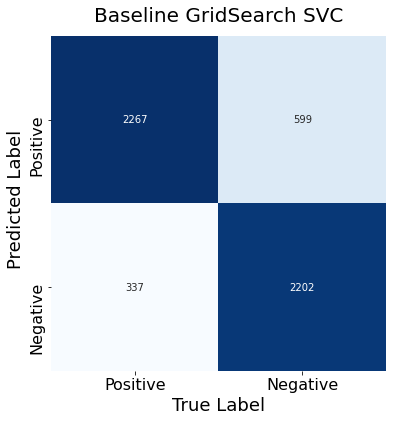

In [309]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test, y_pred_svc_grid)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cmap="Blues")
plt.xlabel('True Label', fontsize= 18)
plt.ylabel('Predicted Label', fontsize= 18)
plt.title('Baseline GridSearch SVC', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
b, t = plt.ylim() 
t -= 0.05 
plt.ylim(b, t) 
plt.savefig('../images/confusion-matrix-ensemble-model.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()